In [209]:
import gcsfs
import os
import jax
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # second gpu
import numpy as np
import pickle
import xarray

from dinosaur import horizontal_interpolation
from dinosaur import spherical_harmonic
from dinosaur import xarray_utils
import neuralgcm

gcs = gcsfs.GCSFileSystem(token='anon')

In [210]:
#here we load the model, let's try with 1.4deg and deterministic
model_name = 'neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl'  #@param ['neural_gcm_dynamic_forcing_deterministic_0_7_deg.pkl', 'neural_gcm_dynamic_forcing_deterministic_1_4_deg.pkl', 'neural_gcm_dynamic_forcing_deterministic_2_8_deg.pkl', 'neural_gcm_dynamic_forcing_stochastic_1_4_deg.pkl'] {type: "string"}

with gcs.open(f'gs://gresearch/neuralgcm/04_30_2024/{model_name}', 'rb') as f:
  ckpt = pickle.load(f)

model = neuralgcm.PressureLevelModel.from_checkpoint(ckpt)

In [211]:
#we first load the ERA5 data that we are interested in:

era5_path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
full_era5 = xarray.open_zarr(gcs.get_mapper(era5_path), chunks=None)

#european heatwave 2022
start_time = '2018-07-22'
end_time = '2018-08-08'
data_inner_steps = 6  # process every 24th hour

sliced_era5 = (
    full_era5
    [model.input_variables + model.forcing_variables]
    .pipe(
        xarray_utils.selective_temporal_shift,
        variables=model.forcing_variables,
        time_shift='24 hours',
    )
    .sel(time=slice(start_time, end_time, data_inner_steps))
    .compute()
)

# Before regridding we need to APPLY the PGW delta to the ERA5 data


In [212]:
sliced_era5

<xarray.Dataset> Size: 78GB
Dimensions:                              (time: 72, level: 37, latitude: 721,
                                          longitude: 1440)
Coordinates:
  * latitude                             (latitude) float32 3kB 90.0 ... -90.0
  * level                                (level) int64 296B 1 2 3 ... 975 1000
  * longitude                            (longitude) float32 6kB 0.0 ... 359.8
  * time                                 (time) datetime64[ns] 576B 2018-07-2...
Data variables:
    geopotential                         (time, level, latitude, longitude) float32 11GB ...
    specific_humidity                    (time, level, latitude, longitude) float32 11GB ...
    temperature                          (time, level, latitude, longitude) float32 11GB ...
    u_component_of_wind                  (time, level, latitude, longitude) float32 11GB ...
    v_component_of_wind                  (time, level, latitude, longitude) float32 11GB ...
    specific_cloud_ice_water_content     (time, level, latitude, longitude) float32 11GB ...
    specific_cloud_liquid_water_content  (time, level, latitude, longitude) float32 11GB ...
    sea_ice_cover                        (time, latitude, longitude) float32 299MB ...
    sea_surface_temperature              (time, latitude, longitude) float32 299MB ...
Attributes:
    valid_time_start:  1940-01-01
    last_updated:      2024-08-27 07:32:47.309165
    valid_time_stop:   2024-05-31

In [213]:
import xarray as xr

path_delta_mm = '/home/bernatj/Data/postprocessed-cmip6/interpolated-2.5deg-multimodel/'

#read delta q for mm mean:  
delta_vars = {'specific_humidity' : 'hus', 'temperature' : 'ta', 'sea_surface_temperature' : 'tos','sea_ice_cover' : 'siconc'}

ds_vars = {}
for var in delta_vars.keys():
    print(var)
    var_cmip6 = delta_vars[var] 
    ds_vars[var] = xr.open_dataset(path_delta_mm+f'{var_cmip6}/{var_cmip6}_multimodel_mean.nc')[var_cmip6]
    

ds_vars = xr.merge(list(ds_vars.values()))

# Create a reversed dictionary that only contains variables that are in the dataset
reversed_dict = {v: k for k, v in delta_vars.items() if v in ds_vars.data_vars}
ds_vars = ds_vars.rename(reversed_dict)

# Convert pressure levels from Pa to hPa
ds_vars['plev'] = ds_vars['plev'] / 100

# Optionally, update the units attribute
ds_vars['plev'].attrs['units'] = 'hPa'

#rename variable to level
ds_vars = ds_vars.rename({'plev' : 'level'})

specific_humidity
temperature
sea_surface_temperature
sea_ice_cover


In [214]:
#levels as in the 37 levels used by NeuralGCM
levels = sliced_era5_pgw.level.values

# Interpolate each variable in the dataset to the new pressure levels
interpolated_ds = xr.Dataset()
for var_name in ds_vars.data_vars:
    if 'level' in ds_vars[var_name].dims:  # Check if the variable depends on pressure
        interpolated_var = ds_vars[var_name].interp(level=levels,method='linear', kwargs={"fill_value": "extrapolate"})
        interpolated_ds[var_name] = interpolated_var.interpolate_na(dim='level', method='linear')
    interpolated_ds[var_name] = ds_vars[var_name]

interpolated_ds = interpolated_ds.interpolate_na(dim='level', method='linear')

#horizontal interpolation to 0,25deg grid
new_lons=np.arange(0,360,0.25)
new_lats=np.arange(90,-90.1,-0.25)
interpolated_grid_ds = interpolated_ds.interp(lon=new_lons, lat=new_lats, method='linear', kwargs={"fill_value": "extrapolate"})
interpolated_grid_ds = interpolated_grid_ds.rename({'lat' : 'latitude', 'lon' : 'longitude'})


In [215]:
def interpolate_to_dayofyear(data, day_of_year, method='linear'):
    """
    Interpolates monthly climatology data to daily climatology data.
    
    Parameters:
        data (xarray.Dataset or xarray.DataArray): Monthly climatology dataset or array.
        day_of_year (int): The day of the year to which the data should be interpolated.
        method (str, optional): Interpolation method. Default is 'linear'.
        
    Returns:
        xarray.Dataset or xarray.DataArray: Daily climatology dataset or array interpolated to the specified day of the year.
    """
    # Number of days per month
    num_days = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

    # Calculate the center day of each month
    dayofyear = [(num_days[i] // 2) + 1 + sum(num_days[0:i]) for i in range(0, 12)]

    # Rename 'time' dimension to 'dayofyear'
    data= data.rename({'time': 'dayofyear'})

    #add one december at the begining and january at the end to be able to interpolate all days
    data_ext = data.pad(dayofyear=1, mode='wrap') 
   
    dayofyear_ext = [dayofyear[0]-30] + dayofyear + [dayofyear[-1]+30]
           
    # Assign new coordinates for 'dayofyear'
    data_ext = data_ext.assign_coords({'dayofyear': dayofyear_ext})

    # Interpolate to the day we are interested
    data_interpolated = data_ext.interp(dayofyear=day_of_year, method=method)

    return data_interpolated

In [216]:
from datetime import datetime

#sliced era modified
sliced_era5_pgw = sliced_era5.copy(deep=False)

#let's start applying the delta for the specific humidity

for i,time in enumerate(sliced_era5_pgw.time.values):
    print(time)

    #intepolate to the specific data
    day_of_year = time.astype('datetime64[s]').astype(datetime).timetuple().tm_yday
    for var in delta_vars.keys():
        print(var)
        if var == 'sea_ice_cover':
            sliced_era5_pgw[var][i] = sliced_era5_pgw[var][i] - 0.01 *  interpolate_to_dayofyear(interpolated_grid_ds[var], day_of_year)
        else:
            sliced_era5_pgw[var][i] = sliced_era5_pgw[var][i] - interpolate_to_dayofyear(interpolated_grid_ds[var], day_of_year)

#make sure sea ice cover does not get below 0
sliced_era5_pgw['sea_ice_cover'] = xr.where(sliced_era5_pgw['sea_ice_cover']<0, 0., sliced_era5_pgw['sea_ice_cover'])

2018-07-22T00:00:00.000000000
specific_humidity
temperature
sea_surface_temperature
sea_ice_cover
2018-07-22T06:00:00.000000000
specific_humidity
temperature
sea_surface_temperature
sea_ice_cover
2018-07-22T12:00:00.000000000
specific_humidity
temperature
sea_surface_temperature
sea_ice_cover
2018-07-22T18:00:00.000000000
specific_humidity
temperature
sea_surface_temperature
sea_ice_cover
2018-07-23T00:00:00.000000000
specific_humidity
temperature
sea_surface_temperature
sea_ice_cover
2018-07-23T06:00:00.000000000
specific_humidity
temperature
sea_surface_temperature
sea_ice_cover
2018-07-23T12:00:00.000000000
specific_humidity
temperature
sea_surface_temperature
sea_ice_cover
2018-07-23T18:00:00.000000000
specific_humidity
temperature
sea_surface_temperature
sea_ice_cover
2018-07-24T00:00:00.000000000
specific_humidity
temperature
sea_surface_temperature
sea_ice_cover
2018-07-24T06:00:00.000000000
specific_humidity
temperature
sea_surface_temperature
sea_ice_cover
2018-07-24T12:00:00.

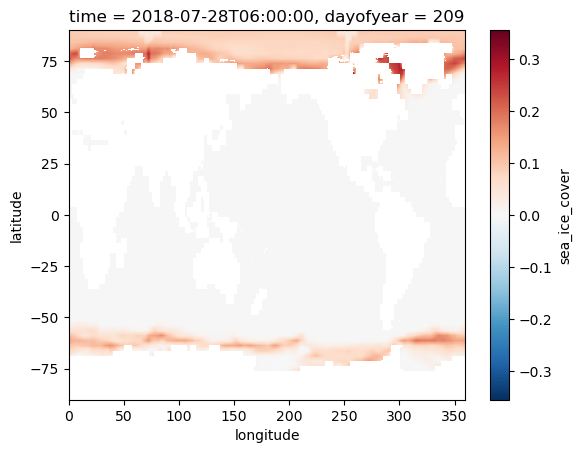

In [198]:
(sliced_era5_pgw['sea_ice_cover'][1,:,:] - sliced_era5['sea_ice_cover'][1,:,:]).plot()


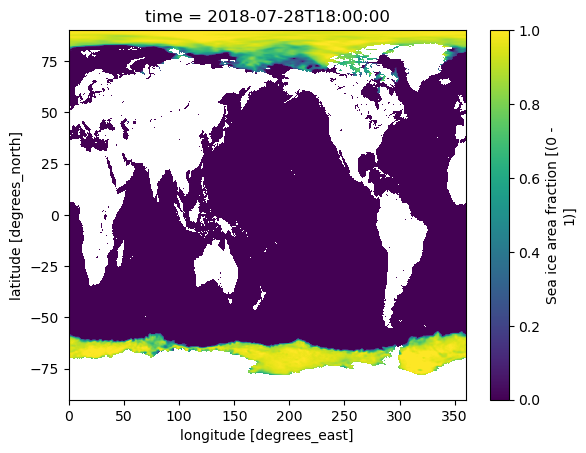

In [199]:
(sliced_era5['sea_ice_cover'][3,:,:]).plot()

# Reggriding to the model grid

In [217]:
### Regriding #####

#definition of the grid. Means we can later try usng different input grids
era5_grid = spherical_harmonic.Grid(
    latitude_nodes=full_era5.sizes['latitude'],
    longitude_nodes=full_era5.sizes['longitude'],
    latitude_spacing=xarray_utils.infer_latitude_spacing(full_era5.latitude),
    longitude_offset=xarray_utils.infer_longitude_offset(full_era5.longitude),
)

#here we define the regrider
regridder = horizontal_interpolation.ConservativeRegridder(
    era5_grid, model.data_coords.horizontal, skipna=True
)

#here is regredding the data
reggrided_era5 = xarray_utils.regrid(sliced_era5_pgw, regridder)
reggrided_era5 = xarray_utils.fill_nan_with_nearest(reggrided_era5) #filling missing values over land

In [218]:
import datetime

#simulation options.
t0_i = datetime.datetime(2018,7,22,0)
t0_f = datetime.datetime(2018,8,8,18)
delta_h = 6

init_times = []
current_time = t0_i
while current_time <= t0_f:
    init_times.append(current_time)
    current_time += datetime.timedelta(hours=delta_h)

## Forecasting
inner_steps = 6  # in hours
outer_steps = 10 * 24 // inner_steps  # total of 10 days
timedelta = np.timedelta64(1, 'h') * inner_steps
times = (np.arange(outer_steps) * inner_steps)  # time axis in hours

#data_storage:
save_path='/pool/usuarios/bernatj/Data/NeuralGCM_forecasts/'


In [219]:
#dictornary between short and long var names
variable_short_names = {
    "u_component_of_wind": "u",
    "v_component_of_wind": "v",
    "geopotential": "z",
    "temperature": "t",
    "specific_humidity": "q",
    "specific_cloud_ice_water_content": "ciwc",
    "specific_cloud_liquid_water_content": "clwc",
    "sea_surface_temperature": "sst",
    "sea_ice_cover": "siconc"
}

In [220]:
exper = 'pgw_t_q_siconc_sst'

for init_time in init_times:
    print(f'simulation for init time: {init_time}')
    
    # initialize model state
    inputs = model.inputs_from_xarray(reggrided_era5.sel(time=init_time))
    input_forcings = model.forcings_from_xarray(reggrided_era5.sel(time=init_time))
    initial_state = model.encode(inputs, input_forcings)

    # use persistence for forcing variables (SST and sea ice cover)
    all_forcings = model.forcings_from_xarray(reggrided_era5.sel(time=init_time).expand_dims({"time": 1}))

    # make forecast
    final_state, predictions = model.unroll(
        initial_state,
        all_forcings,
        steps=outer_steps,
        timedelta=timedelta,
        start_with_input=True,
    )
    predictions_ds = model.data_to_xarray(predictions, times=times)

    # Save the output in a NetCDF file
    print(f'simulation finished... saving data into netcdf')
    yyyymmddhh = init_time.strftime('%Y%m%d%H')
    os.makedirs(save_path+'/'+yyyymmddhh, exist_ok=True)
    for var in predictions_ds:
        if var != 'sim_time':
            short_name = variable_short_names[var]
            ds = predictions_ds[var].to_dataset(name=short_name).transpose('time','level','latitude','longitude')
            ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
            ds.to_netcdf(save_path+f'{yyyymmddhh}/{short_name}_neuralgcm_det_1p4_{exper}_{yyyymmddhh}.nc')

simulation for init time: 2018-07-22 00:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-22 06:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-22 12:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-22 18:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-23 00:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-23 06:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-23 12:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-23 18:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-24 00:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-24 06:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-24 12:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-24 18:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-25 00:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-25 06:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-25 12:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-25 18:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-26 00:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-26 06:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-26 12:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-26 18:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-27 00:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-27 06:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-27 12:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-27 18:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-28 00:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-28 06:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-28 12:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-28 18:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-29 00:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-29 06:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-29 12:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-29 18:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-30 00:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-30 06:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-30 12:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-30 18:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-31 00:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-31 06:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-31 12:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-07-31 18:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-01 00:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-01 06:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-01 12:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-01 18:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-02 00:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-02 06:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-02 12:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-02 18:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-03 00:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-03 06:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-03 12:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-03 18:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-04 00:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-04 06:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-04 12:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-04 18:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-05 00:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-05 06:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-05 12:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-05 18:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-06 00:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-06 06:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-06 12:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-06 18:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-07 00:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-07 06:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-07 12:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-07 18:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-08 00:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-08 06:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-08 12:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil

simulation for init time: 2018-08-08 18:00:00
simulation finished... saving data into netcdf


/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=model.sim_time_to_datetime64(predictions['sim_time']))
/tmp/ipykernel_774557/894981311.py:32: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be sil